# Probando modelos de clasificación binaria 

En esta práctica vamos a construir modelos de clasificación para el dataset ya analizado en la práctica {ref}`exploratory`

El objetivo es clasificar si el cliente se subscribirá a un depósito a largo plazo (clasificación binaria). Recordemos las descripciones de lo que represeta cada columna:
- **Datos del cliente**
    - `age`: edad del candidato
    - `job`: tipo de trabajo el candidato
    - `marital`: estado civil
    - `education`: nivel educativo
    - `default`: ¿Tiene incumplimientos en algún crédito?
    - `housing`: ¿Tiene una hipoteca?
    - `loan`: ¿Tiene un crédito personal?
- **Datos relacionados con el último contacto de la campaña**
    - `contact`: canal de comunicicación de los contactos con el cliente
    - `month`: mes del último contacto en el presente año
    - `day_of_week`: día de la semana del último contacto en el presente año
    - `duration`: duración de la última comunicación en segundos
- **Historial de contactos**
    - `campaign`: número de contactos realizados durante la campaña con el cliente
    - `pdays`: número de días que pasaron desde que el cliente fue contactado en una anterior campaña. Si no hubo contacto, vale `999`
    - `previous`: número de contactos realizados con el cliente antes de esta campaña
    - `poutcome`: resultado de la anterior campaña
- **Variables socioeconómicas**
    - `emp.var.rate`: tasa de variación de empleo (indicador cuatrimestral)
    - `cons.price.idx`: índice de precios de consumo (indicador mensual)
    - `cons.conf.idx`: índice de confianza del consumidor (indicador mensual)
    - `euribor3m`: tasa euribor a 3 meses (indicador diario)
    - `nr.employed`: número de ocupados (indicador cuatrimestral, en miles)
- **Variable objetivo**
    - `y`: ¿Ha contratado el cliente un depósito a largo plazo? 

In [16]:
import os
import urllib
import zipfile
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as ss

In [17]:
working_dir = "."
download_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
bank_path = "data/bank"
raw_data_rel_path = "data/data_raw"
zip_path = "bank-additional/bank-additional-full.csv"
raw_data_path = os.path.join(working_dir, raw_data_rel_path)

In [18]:
def fetch_data(
    download_url: str,
    raw_data_path: str,
    bank_path: str,
    zip_path: str
) -> None:
    os.makedirs(raw_data_path, exist_ok=True)
    zip_file_path = os.path.join(raw_data_path, "data.zip")
    urllib.request.urlretrieve(download_url, zip_file_path)
    with zipfile.ZipFile(zip_file_path) as zip_ref:
        zip_ref.extract(
            zip_path,
            bank_path
        )

def load_data(bank_path: str, zip_path: str) -> pd.DataFrame:
    csv_path = os.path.join(bank_path, zip_path)
    df = pd.read_csv(csv_path, sep=";")
    return df

In [19]:
# funciones auxiliares

def filter_cols(df: pd.DataFrame, rem_cols: List[str]):
    cols = [col for col in df.columns if col not in rem_cols]
    df = df[cols]
    return df 

Cargamos los datos y guardamos la variable objetivo en una serie separada

In [20]:
fetch_data(download_url, raw_data_path, bank_path, zip_path)
bank = load_data(bank_path, zip_path)
y = bank["y"] == "yes"
bank.drop(columns="y", inplace=True)

## Train - Test 

Dividimos nuestro conjunto de datos en dos conjuntos, train y test, usando una división *estratificada* para asegurarnos que la variable objetivo está igualmente representada en ambos conjuntos (recordemos que el conjunto de datos está desbalanceado)

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(bank, y):
    bank_train, bank_test = bank.loc[train_idx], bank.loc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

Por ahora dejamos `bank_test` a un lado para centranos en el procesamiento de variables e implementación de modelos con el conjunto de train.

## Preprocesado 

Las tareas de preprocesado que vamos a llevar a cabo son 

- Vamos a eliminar la columna `duration` porque no es una variable de la que dispongamos cuando el modelo esté en producción
- Basándonos en el análisis exploratorio de datos, nos vamos a quedar solamente con la variable `poutcome` de entre las variables que referencian campañas anteriores. 
- Igualmente, dada la alta correlación entre alguna de las variables categóricas, nos quedamos con `no.employed` en detrimento de `euribor3m` y `emp.var.rate`.

Sería interesante realizar una **reducción de la dimensionalidad** una vez estas variables hayan sido codificadas, pero por simplificar vamos a quedarnos con las que a priori puedan funcionar mejor. 

In [22]:
def preprocess(df: pd.DataFrame):
    rem_cols=["duration", "campaign", "pdays", "previous", "euribor3m", "emp.var.rate"]
    if len(set(rem_cols) - set(df.columns)):
        raise KeyError("Intentando borrar columnas inexistentes")
    df = filter_cols(df, rem_cols=rem_cols)
    return df

In [23]:
bank_train_preprocessed = preprocess(bank_train)

Separamos variables numéricas y categóricas ya que tendrán procesados diferentes

In [24]:
num_cols = bank_train_preprocessed.select_dtypes("number").columns.to_list()
cat_cols = [col for col in bank_train_preprocessed.columns if col not in num_cols]

In [25]:
for col in cat_cols:
    print(f"Columna {col} tiene {bank_train_preprocessed[col].nunique()} valores únicos")

Columna job tiene 12 valores únicos
Columna marital tiene 4 valores únicos
Columna education tiene 8 valores únicos
Columna default tiene 3 valores únicos
Columna housing tiene 3 valores únicos
Columna loan tiene 3 valores únicos
Columna contact tiene 2 valores únicos
Columna month tiene 10 valores únicos
Columna day_of_week tiene 5 valores únicos
Columna poutcome tiene 3 valores únicos


In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

col_transformer = ColumnTransformer([
    ("num", StandardScaler(), num_cols), 
    ("cat", OneHotEncoder(sparse=False), cat_cols)
])
col_transformer.fit(bank_train_preprocessed)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'cons.price.idx', 'cons.conf.idx',
                                  'nr.employed']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week', 'poutcome'])])

In [27]:
def process(df: pd.DataFrame):
    X = col_transformer.transform(df)
    one_hot_attr = col_transformer.transformers_[1][1].get_feature_names_out()
    df_processed = pd.DataFrame(X, columns=[*num_cols, *one_hot_attr])
    return df_processed

In [28]:
bank_train_processed = process(bank_train_preprocessed)

In [29]:
bank_train_processed

,age,cons.price.idx,cons.conf.idx,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.863739,-0.648967,-0.322269,0.398990,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.289722,-0.648967,-0.322269,0.398990,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,3.651268,1.103451,0.045048,-2.420139,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.385843,0.721890,0.887717,0.332723,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.824956,-1.058152,-0.062987,-1.252175,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,-1.154817,1.103451,0.045048,-2.420139,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
32946,1.152104,-0.648967,-0.322269,0.398990,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32947,1.344347,0.590675,-0.473517,0.844915,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
32948,-1.058695,0.721890,0.887717,0.332723,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Modelos

Vamos a probar diferentes tipologías de modelos y estudiar si debemos realizar selección de variables

In [30]:
X_train = bank_train_processed

In [31]:
from sklearn.metrics import make_scorer, precision_score, recall_score, balanced_accuracy_score

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score)
}

### Random Forest

Vamos a entrenar un Random Forest como primera aproximación y para valorar algunas métricas

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

rf_clf = RandomForestClassifier(criterion="entropy")
rf_clf.fit(bank_train_processed, y_train)
rf_clf_scores = cross_validate(rf_clf, bank_train_processed, y_train, cv=3, scoring=scorers)
rf_clf_scores

{'fit_time': array([2.48525953, 3.17371225, 2.45561767]),
 'score_time': array([0.27095628, 0.4005754 , 0.27123022]),
 'test_precision_score': array([0.47959184, 0.44352617, 0.44786096]),
 'test_recall_score': array([0.26575121, 0.26030719, 0.27081649]),
 'test_balanced_accuracy': array([0.6145604 , 0.60942715, 0.61422007])}

### Selección de Variables en RandomForest

Vamos a seleccionar algunas variables utilizando el atributo `feature_importances_` de estimador Random Forest

In [47]:
from sklearn.feature_selection import SelectFromModel

def feature_selection_from_model(estimator, X_df, y, ax=None):
    # Ajustamos SelectFromModel (basado en improtancia de pesos)
    selector = SelectFromModel(estimator)
    selector.fit(X_df, y)
    estimator = selector.estimator_
    # Características seleccionadas
    model_selection_features = selector.get_feature_names_out()
    # Obtenemos importancias de las características
    n_features = X_df.shape[1]
    importances = estimator.feature_importances_
    # Si las importancias vienen como array multidimensional hacemos la media
    if importances.shape != (n_features,):
        importances = estimator.feature_importances_.mean(axis=0)
            
    print('Número de características seleccionadas :', len(model_selection_features),'\n')
    print('Características seleccionadas :', model_selection_features,'\n')
    
    if ax is not None:
        #Realizamos un grafico de barras con la importancia de las características
        ax.barh(range(n_features), importances, align='center') 
        ax.set_yticks(np.arange(n_features)) 
        ax.set_yticklabels(X_df.columns.values)
        ax.set_xlabel('Feature importance')
        ax.set_ylabel('Feature')
    
    return set(model_selection_features)

Número de características seleccionadas : 16 

Características seleccionadas : ['age' 'cons.price.idx' 'cons.conf.idx' 'nr.employed' 'job_admin.'
 'marital_married' 'education_high.school' 'education_university.degree'
 'housing_no' 'housing_yes' 'day_of_week_fri' 'day_of_week_mon'
 'day_of_week_thu' 'day_of_week_tue' 'day_of_week_wed' 'poutcome_success'] 



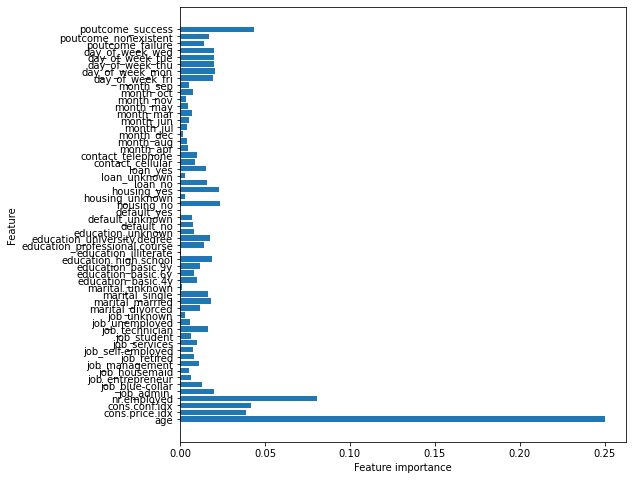

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))

rf_selected_features = feature_selection_from_model(
    RandomForestClassifier(), 
    X_train, 
    y_train, 
    ax=ax
)

In [49]:
X_train_selected = X_train[list(rf_selected_features)]

### Elección de modelo

Definamos varias tipologías de modelos de clasificación y evaluemos diferentes métricas utilizando *validación cruzada* y estudiando si la selección de variables mejora o entorpece a los modelos

In [50]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


# Añadimos la variable rmse porque usaremos esta función también en el problema de regresión
def compare_models(
    models, 
    X,
    y,
    scoring,
    n_splits=5,
    seed=None, 
    rmse=False, 
    ax=None
):
    # lista de resultados de la validación cruzada y nombres de los algoritmos
    results = []
    names = []
    print('Estadísticas para la métrica {} con CV de {} folds:'.format(scoring,n_splits))
    for name, model in models:
        # generamos los folds
        kfold = model_selection.KFold(n_splits=n_splits, random_state=seed, shuffle=True)
        # realizamos cv
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        names.append(name)
        if not rmse:
            msg = "\t Algoritmo {}: Media = {}, desviación estándar = {}"\
            .format(name, cv_results.mean(), cv_results.std())
        else:
            cv_results = np.sqrt(-cv_results)
            msg = "\t Algoritmo {}: RMSE medio = {}, desviación estándar = {}"\
            .format(name,  cv_results.mean(), cv_results.std())
        print(msg)
        results.append(cv_results)
        
    if ax:
        # Generamos una gráfica de cajas y bigotes para cada algoritmo
        ax.boxplot(results)
        ax.set_xticklabels(names)
    
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
seed = 42

Estadísticas para la métrica precision con CV de 5 folds:
	 Algoritmo LR: Media = 0.6537112298575428, desviación estándar = 0.04505003208388039
	 Algoritmo KNN: Media = 0.5018652402303204, desviación estándar = 0.017209994309733422
	 Algoritmo CART: Media = 0.3180014187727558, desviación estándar = 0.014477673941583336
	 Algoritmo NB: Media = 0.29607913342044667, desviación estándar = 0.006642479028008792
	 Algoritmo GB: Media = 0.6557179158970226, desviación estándar = 0.02554074375762445
	 Algoritmo RF: Media = 0.4706481877959618, desviación estándar = 0.023514602653537234
Estadísticas para la métrica precision con CV de 5 folds:
	 Algoritmo LR: Media = 0.7066021820666908, desviación estándar = 0.03573849702901917
	 Algoritmo KNN: Media = 0.49532590839127505, desviación estándar = 0.04187479920970608
	 Algoritmo CART: Media = 0.3688983946420342, desviación estándar = 0.030458546012721608
	 Algoritmo NB: Media = 0.4777581713827562, desviación estándar = 0.005469361156502378
	 Algoritm

Text(0.5, 0.98, 'Comparación de modelos: precisión')

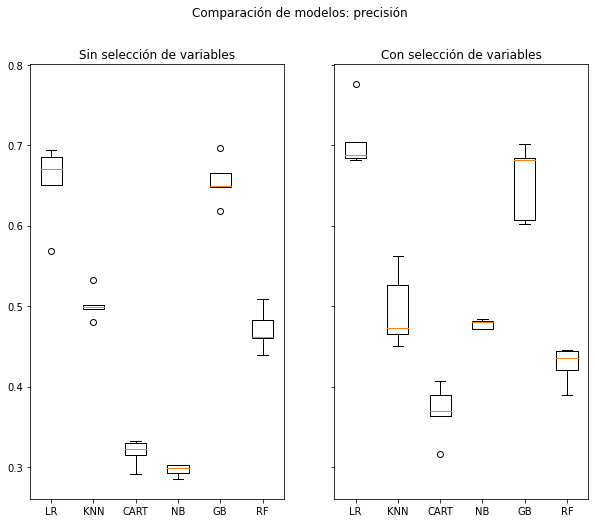

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

compare_models(
    models, 
    X_train, 
    y_train, 
    scoring="precision", 
    ax=ax[0]
)
ax[0].set_title("Sin selección de variables")

compare_models(
    models, 
    X_train_selected, 
    y_train, 
    scoring="precision", 
    ax=ax[1]
)
ax[1].set_title("Con selección de variables")

fig.suptitle("Comparación de modelos: precisión")

Estadísticas para la métrica recall con CV de 5 folds:
	 Algoritmo LR: Media = 0.2181927445186544, desviación estándar = 0.00299329691407742
	 Algoritmo KNN: Media = 0.2569701580658597, desviación estándar = 0.011060885052020235
	 Algoritmo CART: Media = 0.3175880615281605, desviación estándar = 0.010211354267065343
	 Algoritmo NB: Media = 0.6394285864341301, desviación estándar = 0.09181451156932478
	 Algoritmo GB: Media = 0.23316212233899022, desviación estándar = 0.010782454118125475
	 Algoritmo RF: Media = 0.2832720540623217, desviación estándar = 0.016312265193180863
Estadísticas para la métrica recall con CV de 5 folds:
	 Algoritmo LR: Media = 0.17434248939036084, desviación estándar = 0.00856237991888306
	 Algoritmo KNN: Media = 0.20916454680004642, desviación estándar = 0.014521324732371808
	 Algoritmo CART: Media = 0.2801874703780247, desviación estándar = 0.012346156945975564
	 Algoritmo NB: Media = 0.3311612535402707, desviación estándar = 0.01689304370542162
	 Algoritmo GB:

Text(0.5, 0.98, 'Comparación de modelos: sensibilidad')

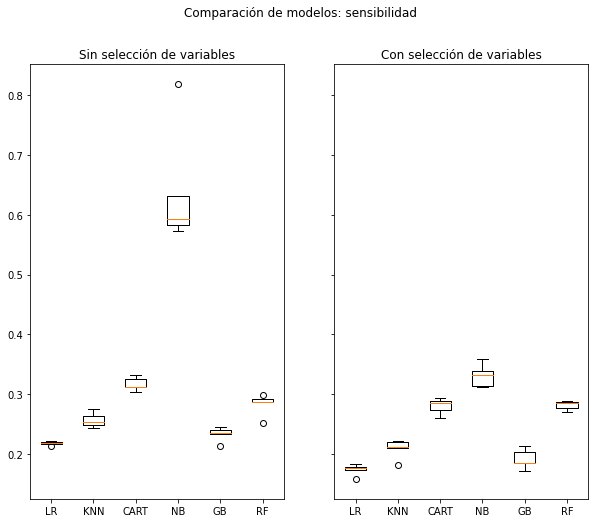

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

compare_models(
    models, 
    X_train, 
    y_train, 
    scoring="recall", 
    ax=ax[0]
)
ax[0].set_title("Sin selección de variables")

compare_models(
    models, 
    X_train_selected, 
    y_train, 
    scoring="recall", 
    ax=ax[1]
)
ax[1].set_title("Con selección de variables")

fig.suptitle("Comparación de modelos: sensibilidad")

Estadísticas para la métrica balanced_accuracy con CV de 5 folds:
	 Algoritmo LR: Media = 0.6022452548722621, desviación estándar = 0.0037558003497701296
	 Algoritmo KNN: Media = 0.613613063836481, desviación estándar = 0.003682816043533694
	 Algoritmo CART: Media = 0.6108162164514364, desviación estándar = 0.00966980158477819
	 Algoritmo NB: Media = 0.7077842371100556, desviación estándar = 0.009353313726109064
	 Algoritmo GB: Media = 0.6078863379057845, desviación estándar = 0.004313713893399986
	 Algoritmo RF: Media = 0.6139460361771683, desviación estándar = 0.00537866142233999
Estadísticas para la métrica balanced_accuracy con CV de 5 folds:
	 Algoritmo LR: Media = 0.5824039704510712, desviación estándar = 0.004556580545801131
	 Algoritmo KNN: Media = 0.5880966994693504, desviación estándar = 0.006482306581873072
	 Algoritmo CART: Media = 0.6110935971110217, desviación estándar = 0.007027948334326948
	 Algoritmo NB: Media = 0.6426314240409645, desviación estándar = 0.0155601187638

Text(0.5, 0.98, 'Comparación de modelos: exactitud balanceada')

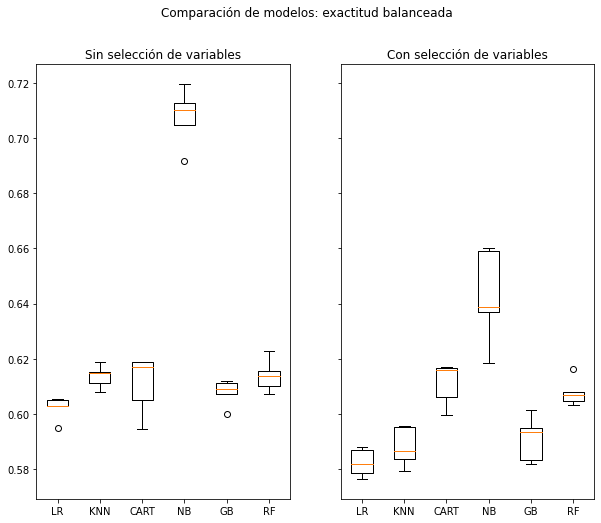

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

compare_models(
    models, 
    X_train, 
    y_train, 
    scoring="balanced_accuracy", 
    ax=ax[0]
)
ax[0].set_title("Sin selección de variables")

compare_models(
    models, 
    X_train_selected, 
    y_train, 
    scoring="balanced_accuracy", 
    ax=ax[1]
)
ax[1].set_title("Con selección de variables")

fig.suptitle("Comparación de modelos: exactitud balanceada")

Llegados a este punto, tenemos que preguntarnos **qué métrica queremos maximizar** de cara a que nuestro modelo aporte valor. Como en todo problema de clasificación, siempre hay un tira y afloja entre precisión y sensibilidad, luego no podemos tener un modelo que lo haga bien para ambas métricas. 

No podemos olvidar que una de las principales aplicaciones de esta clasificación es la **detección de potenciales clientes** con los que vamos a contactar para ofrecerles un depósito en el banco. Por lo tanto, en principio no deberíamos preocuparnos por los falsos negativos (en contraposición con un problema de, digamos, detectar una enfermedad peligrosa). Dejarnos potenciales contratadores atrás no es un problema siempre y cuando **podamos asegurar una precisión alta** en aquellos que elijamos. 

> Tomaremos la precisión como nuestra métrica de referencia, controlando siempre el resto. En consecuencia, vamos a escoger una regresión logística con selección de variables para realizar tuneado de hiperparámetros 

Dicho esto, esta decisión dependerá de detalles más concretos del negocio como la capacidad del centro de llamadas

## Tuneo de hiperparámetros

In [54]:
from sklearn.model_selection import GridSearchCV

lr_param_grid = [
    {
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"], 
        "tol": [1e-4, 1e-5], 
        "max_iter": [100, 500]
    }
]
rnd_grid_search = GridSearchCV(
    LogisticRegression(),
    lr_param_grid,
    cv=3,
    scoring="precision",
    return_train_score=True
)
rnd_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'max_iter': [100, 500], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear'], 'tol': [0.0001, 1e-05]}],
             return_train_score=True, scoring='precision')

In [55]:
cvres = rnd_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6580703259473997 {'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
0.6580703259473997 {'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 1e-05}
0.6562492553776148 {'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
0.6562492553776148 {'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-05}
0.6580703259473997 {'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
0.6580703259473997 {'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 1e-05}
0.6562492553776148 {'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
0.6562492553776148 {'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-05}


In [56]:
from sklearn.model_selection import GridSearchCV

lr_param_grid = [
    {
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"], 
        "tol": [1e-4, 1e-5], 
        "max_iter": [100, 1000], 
        "fit_intercept": [True, False], 
        "intercept_scaling": [1, 0.1, 10]
    }
]
rnd_grid_search = GridSearchCV(
    LogisticRegression(),
    lr_param_grid,
    cv=3,
    scoring="precision",
    return_train_score=True
)
rnd_grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'fit_intercept': [True, False],
                          'intercept_scaling': [1, 0.1, 10],
                          'max_iter': [100, 1000], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear'], 'tol': [0.0001, 1e-05]}],
             return_train_score=True, scoring='precision')

In [57]:
cvres = rnd_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.7101945130327021 {'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
0.7101945130327021 {'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 1e-05}
0.7101945130327021 {'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
0.7101945130327021 {'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-05}
0.7101945130327021 {'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
0.7101945130327021 {'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 1e-05}
0.7101945130327021 {'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
0.7101945130327021 {'fit_in

In [58]:
# Elegimos nuestro clasificador
clf = rnd_grid_search.best_estimator_

## Curva de precisión - sensibilidad

In [59]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_threshold(clf, X, y, threshold=.5, ax=None):
    clf_probs = clf.predict_proba(X)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y,clf_probs)
    # Buscamos el umbral más cercano al dado disponible en thresholds 
    threshold_index = min(range(len(thresholds)), key=lambda i: abs(thresholds[i]-threshold))
    valid_threshold = thresholds[threshold_index] 
    
    # Precision y recall de ese umbral
    precision_threshold = precisions[threshold_index]
    recall_threshold = recalls[threshold_index]
    
    print('Precisión en el umbral {} = %.3f'.format(threshold) % precision_threshold)
    print('Sensibilidad en el umbral {} = %.3f'.format(threshold) % recall_threshold)
    
    if ax:
        # Gráfica
        ax.set_title('Precisión vs Sensibilidad')
        ax.plot(thresholds, precisions[:-1],'b--', label = 'Precisión')
        ax.plot(thresholds, recalls[:-1],'g-', label = 'Sensibilidad')
        ax.plot(valid_threshold, precision_threshold, 'r.', markersize=12,label = 'Umbral = {}'.format(threshold))
        ax.plot(valid_threshold,recall_threshold, 'r.', markersize=12)
        ax.plot([valid_threshold,valid_threshold],[0,max(recall_threshold,precision_threshold)], 'r--')
        ax.plot([0,valid_threshold],[precision_threshold,precision_threshold], 'r--')
        ax.plot([0,valid_threshold],[recall_threshold,recall_threshold], 'r--')
        ax.set_xlabel('Threshold')
        ax.legend()
        ax.set_xlim([0, 1.05])
        ax.grid()

Precisión en el umbral 0.5 = 0.712
Sensibilidad en el umbral 0.5 = 0.175


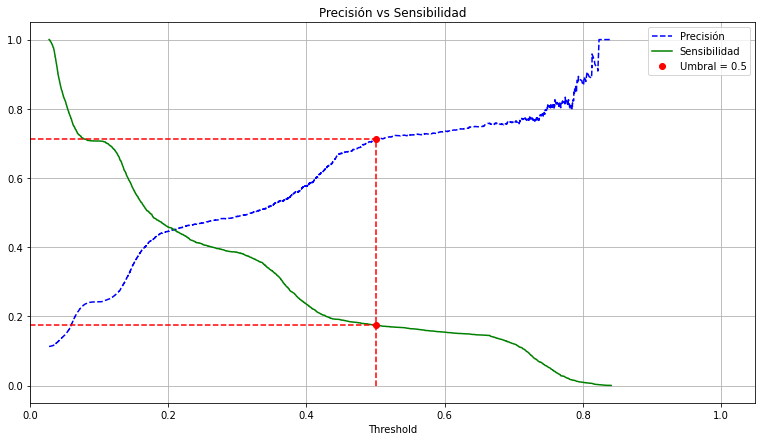

In [60]:
fig, ax = plt.subplots(figsize=(13, 7))

plot_precision_recall_threshold(clf, X_train_selected, y_train, ax=ax)

Con el umbral por defecto, tenemos una sensibilidad del 0.17%.  

## Testeamos modelo

In [61]:
def pipeline(df: pd.DataFrame) -> pd.DataFrame:
    df = preprocess(df)
    df = process(df)
    df = df[list(rf_selected_features)]
    return df

In [62]:
X_test = pipeline(bank_test)

In [63]:
y_test_pred = clf.predict(X_test)

In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)

array([[7256,   54],
       [ 769,  159]])

In [65]:
precision_score(y_test, y_test_pred)

0.7464788732394366

In [66]:
recall_score(y_test, y_test_pred)

0.1713362068965517

Las métricas se mantienen en el test set. 

## Guardado de modelos y transformadores

In [70]:
from joblib import dump

model_path = "model.joblib"
transformer_path = "transformer.joblib"

open(model_path, "w")
dump(clf, model_path)
open(transformer_path, "w")
dump(col_transformer, transformer_path)

['transformer.joblib']

In [71]:
clf.feature_names_in_

array(['day_of_week_wed', 'cons.conf.idx', 'education_university.degree',
       'housing_no', 'day_of_week_mon', 'education_high.school',
       'day_of_week_thu', 'cons.price.idx', 'day_of_week_fri',
       'nr.employed', 'housing_yes', 'day_of_week_tue', 'age',
       'poutcome_success', 'job_admin.', 'marital_married'], dtype=object)